In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import welch

import auxlib

In [2]:
saving_figs = os.path.join(os.getcwd(), 'figures/psd_analysis')
if not os.path.exists(saving_figs):
	os.makedirs(saving_figs)

saving_files = os.path.join(os.getcwd(), 'media/psd_analysis')
if not os.path.exists(saving_files):
	os.makedirs(saving_files)

In [ ]:
data, signal_headers, header = auxlib.loadEEG(subject=10, record=1)

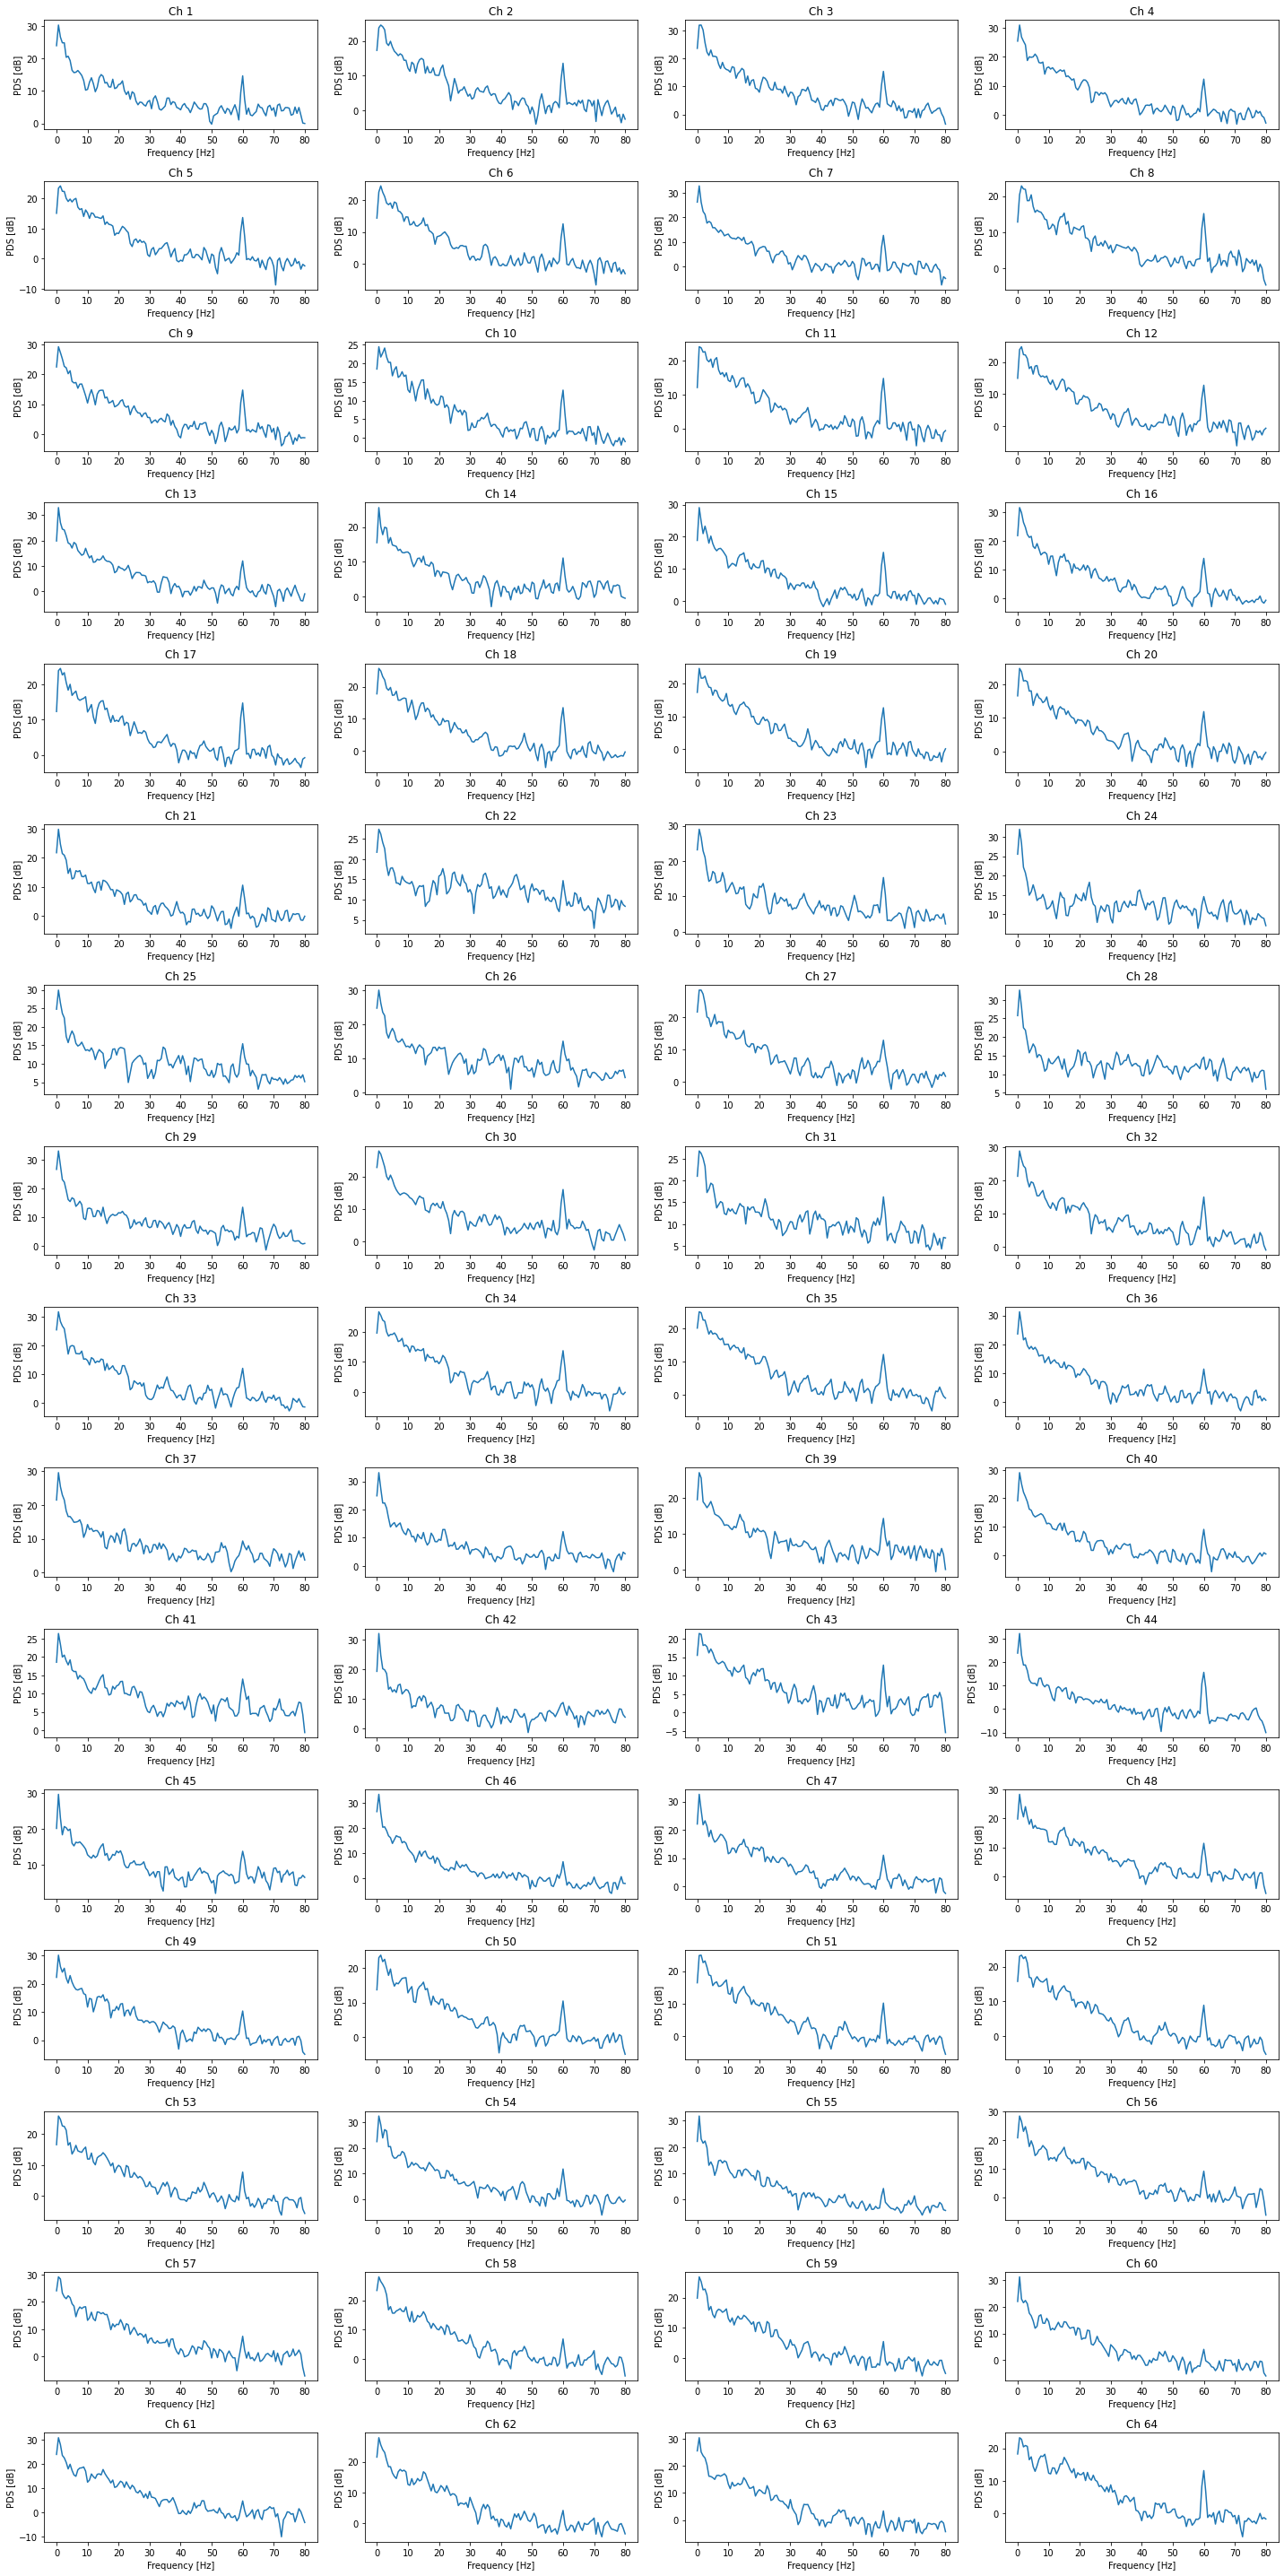

In [9]:
subject, data, _, labels, channels = auxlib.GetSignal(10, 'RL', sample_rate=160, segment_length=1040, selected_channels=None)

fs = 160.0
fig, axs = plt.subplots(16, 4, figsize=(20, 40))

signals = data[0]

for ch in range(1, 65):
	x = signals[ch-1]
	f, Pxx = welch(x, fs, scaling='density')

	Pxx_dB = 10 * np.log10(Pxx)

	axs[(ch-1)//4, (ch-1)%4].plot(f, Pxx_dB)
	axs[(ch-1)//4, (ch-1)%4].set_ylabel('PDS [dB]')
	#axs[(ch-1)//4, (ch-1)%4].set_ylim(0, 7)
	axs[(ch-1)//4, (ch-1)%4].set_xlabel('Frequency [Hz]')
	axs[(ch-1)//4, (ch-1)%4].set_title("Ch {}".format(ch))

# Layout so plots do not overlap
fig.tight_layout()
#fig.savefig('S055R03_spectrogram.png', dpi=300)
fig.savefig(os.path.join(saving_figs, 'S001R03_psd_all_channels.png'), dpi=300, bbox_inches='tight')
plt.show()

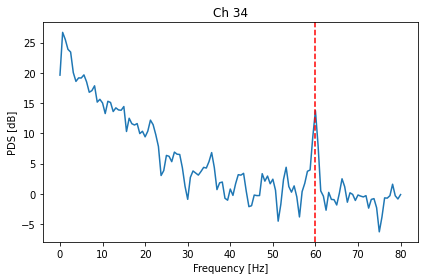

In [44]:
subject, data, _, labels, channels = auxlib.GetSignal(10, 'RL', sample_rate=160, segment_length=1040, selected_channels=None)

fs = 160.0
fig, axs = plt.subplots(1, 1)

signals = data[0]

x = signals[33]
f, Pxx = welch(x, fs, scaling='density')

Pxx_dB = 10 * np.log10(Pxx)

axs.plot(f, Pxx_dB)
axs.set_ylabel('PDS [dB]')
axs.set_xlabel('Frequency [Hz]')
axs.axvline(x=60, color='r', linestyle='--', label='60 Hz')
axs.set_title("Ch {}".format(34))

# Layout so plots do not overlap
fig.tight_layout()
#fig.savefig('S055R03_spectrogram.png', dpi=300)
fig.savefig(os.path.join(saving_figs, 'S010R03_psd_no-filter.png'), dpi=300, bbox_inches='tight')
plt.show()

## Notch filter

In [8]:
from scipy.fft import fft, fftfreq

subject, data, _, labels, channels = auxlib.GetSignal(10, 'RL', sample_rate=160, segment_length=1040, selected_channels=None)
signals = data[0]
x_signal = signals[33]
# Filter Notch Design
fs = 160  # Sample frequency (Hz)
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 98.0  # Quality factor, tipical 1-100, higher values sharps the reject band 

# IIR notch filter using signal.iirnotch
b, a = signal.iirnotch(f0, Q, fs)

# Compute magnitude response of the designed filter
freq, h = signal.freqz(b, a, fs=fs)

# Apply notch filter to signal using signal.filtfilt
signal_filtered = signal.filtfilt(b, a, x_signal)

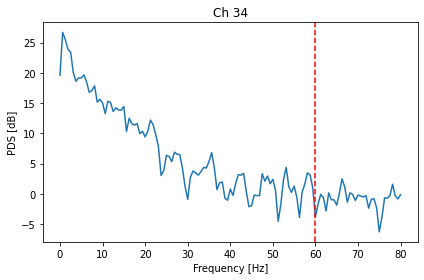

In [9]:
fs = 160.0
fig, axs = plt.subplots(1, 1)

signals = signal_filtered

x = signals
f, Pxx = welch(x, fs, scaling='density')

Pxx_dB = 10 * np.log10(Pxx)

axs.plot(f, Pxx_dB)
axs.set_ylabel('PDS [dB]')
axs.set_xlabel('Frequency [Hz]')
axs.axvline(x=60, color='r', linestyle='--', label='60 Hz')
axs.set_title("Ch {}".format(34))

# Layout so plots do not overlap
fig.tight_layout()
#fig.savefig('S055R03_spectrogram.png', dpi=300)
fig.savefig(os.path.join(saving_figs, 'S010R03_psd_filtered.png'), dpi=300, bbox_inches='tight')
plt.show()

# PSD dB menos baseline

In [3]:
data, signal_headers, header = auxlib.loadEEG(subject=10, record=1)

In [4]:
len(data)

64

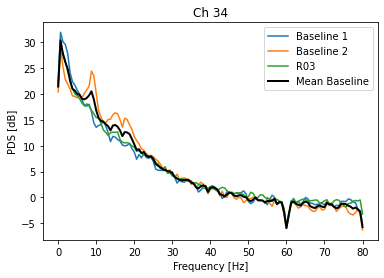

In [24]:
fs = 160.0

fig, axs = plt.subplots(1, 1)

mean_psd = []
for runs in [1, 2]:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=runs)

	signal = auxlib.notch_filter(data[33], f0=60.0, Q=99.99, fs=fs)

	f, Pxx = welch(signal, fs, scaling='density')
	Pxx_dB = 10 * np.log10(Pxx)
	mean_psd.append(Pxx_dB)
	axs.plot(f, Pxx_dB, label='Baseline {}'.format(runs))

data, signal_headers, header = auxlib.loadEEG(subject=10, record=3)

signal = auxlib.notch_filter(data[33], f0=60.0, Q=99.99, fs=fs)

f, Pxx = welch(signal, fs, scaling='density')
Pxx_dB = 10 * np.log10(Pxx)
axs.plot(f, Pxx_dB, label='R03')

mean_psd = np.mean(mean_psd, axis=0)

axs.plot(f, mean_psd, label='Mean Baseline', color='black', linewidth=2)
axs.legend()
axs.set_title("Ch {}".format(34))
axs.set_ylabel('PDS [dB]')
axs.set_xlabel('Frequency [Hz]')


plt.savefig(os.path.join(saving_figs, 'S010R03_psd_baseline.png'), dpi=300, bbox_inches='tight')

Ahora con run $R03$

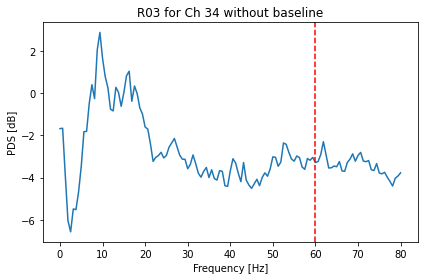

In [ ]:
fs = 160.0
fig, axs = plt.subplots(1, 1)

data, signal_headers, header = auxlib.loadEEG(subject=10, record=runs)

signal = auxlib.notch_filter(data[33], f0=60.0, Q=99.99, fs=fs)

f, Pxx = welch(signal, fs, scaling='density')
Pxx_dB = 10 * np.log10(Pxx)

# normalize PSD and baseline
Pxx_dB_norm = Pxx_dB / (sum(Pxx_dB) * 80/len(Pxx_dB))
baseline_norm = mean_psd / (sum(mean_psd) * 80/len(mean_psd))

Pxx_dB -= mean_psd  # Subtract baseline

axs.plot(f, Pxx_dB)
axs.set_ylabel('PDS [dB]')
axs.set_xlabel('Frequency [Hz]')
axs.axvline(x=60, color='r', linestyle='--', label='60 Hz')
axs.set_title("R03 for Ch {} without baseline".format(34))

# Layout so plots do not overlap
fig.tight_layout()
#fig.savefig('S055R03_spectrogram.png', dpi=300)
#fig.savefig(os.path.join(saving_figs, 'S010R03_psd_filtered.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
data, signal_headers, header = auxlib.loadEEG(subject=10, record=3)

t0_labels, t1_labels, t2_labels = auxlib.task_labels(signal_headers)

data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
                                        t0_labels=t0_labels, 
										t1_labels=t1_labels, 
										t2_labels=t2_labels, t_left=2.0, t_right=2.0)

In [ ]:
fs = 160.0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = [3, 7, 11]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=run)

	t0_labels, t1_labels, t2_labels = auxlib.task_labels(header)

	data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
											t0_labels=t0_labels, 
											t1_labels=t1_labels, 
											t2_labels=t2_labels, t_left=2.0, t_right=2.0)
	
	i = 0
	task_list = ['T0', 'T1', 'T2']
	for data_segment in [data_t0, data_t1, data_t2]:
		total_psd = []
		for j in range(len(data_segment)):
			x = data_segment[j]

			x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

			x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)

			Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
			total_psd.append(Psd_per)
		Psd_per = np.mean(total_psd, axis=0)
	
		axs[i].plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
	
		axs[i].set_ylabel('PDS (Normalized)')
		axs[i].set_xlabel('Frequency [Hz]')	
		axs[i].set_title(f"Task = {task_list[i]}")
		axs[i].legend()
		axs[i].set_xlim(0, 5)
		i += 1

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S010_psd_task_real.png'), dpi=300, bbox_inches='tight')

plt.show()

## PSD porcentual

In [3]:
def psd_percentage(x, fs, nfft):
    
    N = nfft
    X = abs(fft(x, n=nfft))/N
    Pxx = X**2
    X = X[0:int(N/2)+1]
    X[1:int(N/2)] = 2*X[1:int(N/2)] # duplicate except 0
    
    Pxx = Pxx[0:int(N/2)+1]
    
    Pxx[1:int(N/2)] = 2*Pxx[1:int(N/2)]

    #Psd = (1/fs*N)*abs(fft(x, n=nfft))**2
    #Psd = Psd[0:int(N/2)+1]
    #Psd[1:int(N/2)] = 2*Psd[1:int(N/2)] # duplicate except 0
    
    f, S = signal.periodogram(x, fs,  nfft=nfft, scaling='spectrum')

    #psd_sum = sum(Psd)
    
    #Psd_per= Psd/psd_sum
    
    #Psd_per= (nfft/fs)*(Psd/psd_sum)
    
    #f = (fs/N)*np.arange(0, int(N/2)+1, 1) = S
    
    Psd_per = S
    
    psd_sum = sum(Psd_per)
    
    Psd_per= Psd_per/psd_sum
    
    return Psd_per, Pxx, X, f

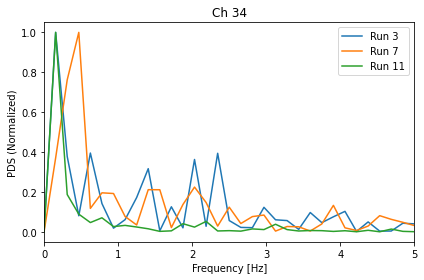

In [39]:
fs = 160.0

fig, axs = plt.subplots(1, 1)

runs = [3, 7, 11]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=run)
	
	x = data[33]  # Channel 34 (index 33)
	
	x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

	x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)
	
	# Calculate PSD
	Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
	
	axs.plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
axs.set_ylabel('PDS (Normalized)')
axs.set_xlabel('Frequency [Hz]')	
axs.set_title("Ch {}".format(34))
axs.legend()
axs.set_xlim(0, 5)

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S010_psd_runsRH-LH.png'), dpi=300, bbox_inches='tight')

plt.show()

# PSD porcentual sobre la data fragmentada por tarea

In [ ]:
data, signal_headers, header = auxlib.loadEEG(subject=10, record=3)

t0_labels, t1_labels, t2_labels = auxlib.task_labels(signal_headers)

data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
                                        t0_labels=t0_labels, 
										t1_labels=t1_labels, 
										t2_labels=t2_labels, t_left=2.0, t_right=2.0)

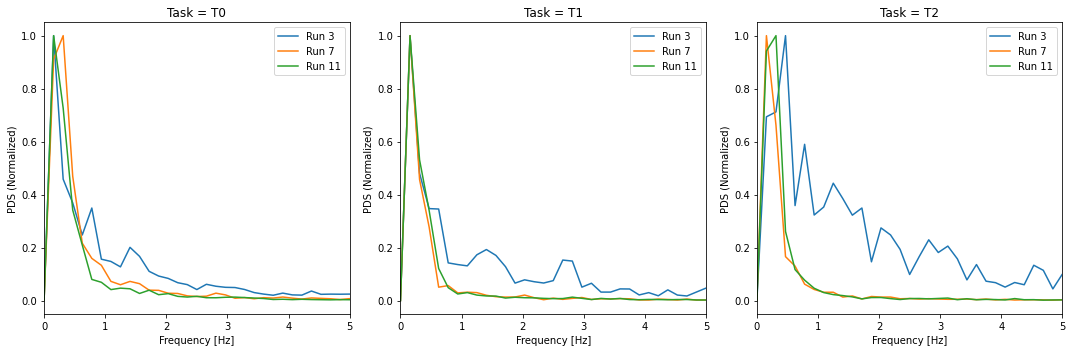

In [ ]:
fs = 160.0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = [3, 7, 11]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=run)

	t0_labels, t1_labels, t2_labels = auxlib.task_labels(header)

	data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
											t0_labels=t0_labels, 
											t1_labels=t1_labels, 
											t2_labels=t2_labels, t_left=2.0, t_right=2.0)
	
	i = 0
	task_list = ['T0', 'T1', 'T2']
	for data_segment in [data_t0, data_t1, data_t2]:
		total_psd = []
		for j in range(len(data_segment)):
			x = data_segment[j]

			x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

			x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)

			Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
			total_psd.append(Psd_per)
		Psd_per = np.mean(total_psd, axis=0)
	
		axs[i].plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
	
		axs[i].set_ylabel('PDS (Normalized)')
		axs[i].set_xlabel('Frequency [Hz]')	
		axs[i].set_title(f"Task = {task_list[i]}")
		axs[i].legend()
		axs[i].set_xlim(0, 5)
		i += 1

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S010_psd_task_real.png'), dpi=300, bbox_inches='tight')

plt.show()

#### runs 4, 8 y 12 

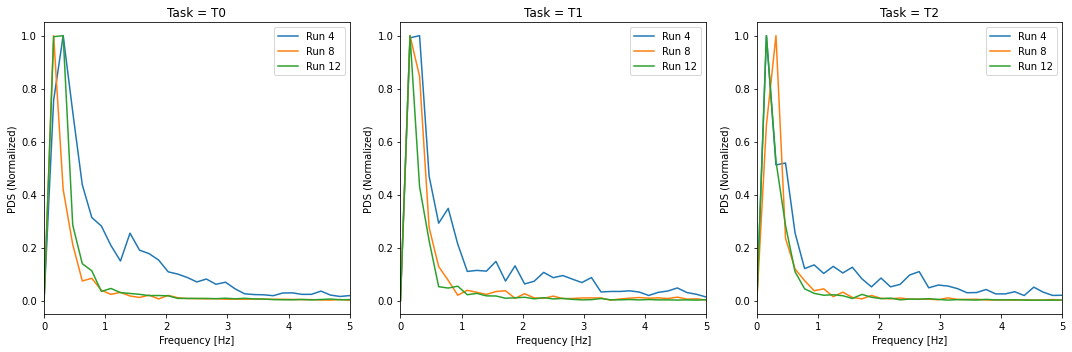

In [51]:
fs = 160.0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = [4, 8, 12]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=run)

	t0_labels, t1_labels, t2_labels = auxlib.task_labels(header)

	data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
											t0_labels=t0_labels, 
											t1_labels=t1_labels, 
											t2_labels=t2_labels, t_left=2.0, t_right=2.0)
	
	i = 0
	task_list = ['T0', 'T1', 'T2']
	for data_segment in [data_t0, data_t1, data_t2]:
		total_psd = []
		for j in range(len(data_segment)):
			x = data_segment[j]

			x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

			x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)

			Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
			total_psd.append(Psd_per)
		Psd_per = np.mean(total_psd, axis=0)
	
		axs[i].plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
	
		axs[i].set_ylabel('PDS (Normalized)')
		axs[i].set_xlabel('Frequency [Hz]')	
		axs[i].set_title(f"Task = {task_list[i]}")
		axs[i].legend()
		axs[i].set_xlim(0, 5)
		i += 1

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S010_psd_task_imag.png'), dpi=300, bbox_inches='tight')

plt.show()

#### sujeto 30

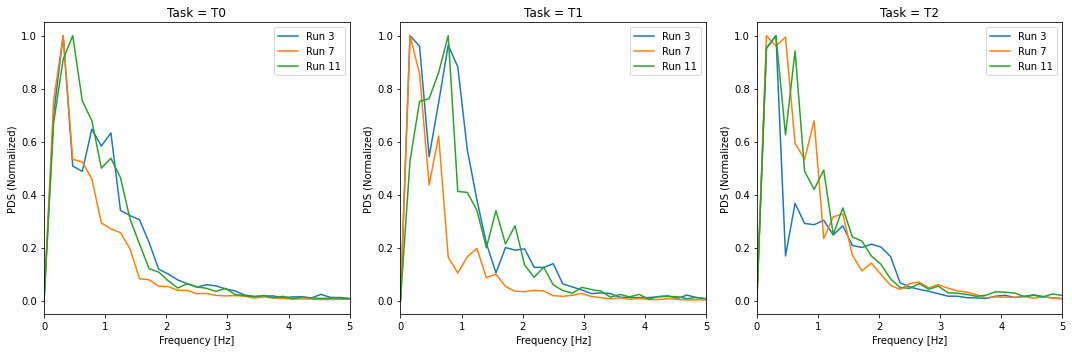

In [53]:
fs = 160.0

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = [3, 7, 11]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=30, record=run)

	t0_labels, t1_labels, t2_labels = auxlib.task_labels(header)

	data_t0, data_t1, data_t2 = auxlib.task_fragmentation(data=data, channel=34, 
											t0_labels=t0_labels, 
											t1_labels=t1_labels, 
											t2_labels=t2_labels, t_left=2.0, t_right=2.0)
	
	i = 0
	task_list = ['T0', 'T1', 'T2']
	for data_segment in [data_t0, data_t1, data_t2]:
		total_psd = []
		for j in range(len(data_segment)):
			x = data_segment[j]

			x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

			x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)

			Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
			total_psd.append(Psd_per)
		Psd_per = np.mean(total_psd, axis=0)
	
		axs[i].plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
	
		axs[i].set_ylabel('PDS (Normalized)')
		axs[i].set_xlabel('Frequency [Hz]')	
		axs[i].set_title(f"Task = {task_list[i]}")
		axs[i].legend()
		axs[i].set_xlim(0, 5)
		i += 1

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S030_psd_task_real.png'), dpi=300, bbox_inches='tight')

plt.show()

## psd en dB

In [ ]:
fs = 160.0

fig, axs = plt.subplots(1, 1)

runs = [3, 7, 11]

for run in runs:
	data, signal_headers, header = auxlib.loadEEG(subject=10, record=run)
	
	x = data[33]  # Channel 34 (index 33)
	
	x_highpass = auxlib.butter_highpass_filtering(x, order=4, f_cutoff=1.0, fs=fs)

	x_filtered = auxlib.notch_filter(x, f0=60.0, Q=98.0, fs=fs)
	
	# Calculate PSD
	Psd_per, Pxx, X, f = psd_percentage(x_filtered, fs, nfft=1024)
	
	axs.plot(f, Psd_per/max(Psd_per), label=f'Run {run}')
axs.set_ylabel('PDS (Normalized)')
axs.set_xlabel('Frequency [Hz]')	
axs.set_title("Ch {}".format(34))
axs.legend()
axs.set_xlim(0, 5)

# Layout so plots do not overlap
fig.tight_layout()
fig.savefig(os.path.join(saving_figs, 'S010_psd_runsRH-LH.png'), dpi=300, bbox_inches='tight')

plt.show()